In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import networkx as nx
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import subprocess
import pandas as pd

from nosh.sim import NoshGraphSimulation
import nosh.utils as uu

In [91]:
### Set up the simulation
###  In this, we don't alter reputation scores for simplicity, we can change this assumption later
initial_buyers_kwargs = [
    {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
    {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
    {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
]
initial_sellers_kwargs = [
    {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
    {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
    {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }, 
]
new_buyer_kwargs = {
    'transact_probability': 0.3,
    'reputation_process_kwargs': {
        'mu': 0,
        'sigma': 0,
        'start_value': 1,
    }
}
new_seller_kwargs = {
    'transact_probability': 1.0, 
    'unstake_probability': 0.0,
    'reputation_process_kwargs': {
        'mu': 0,
        'sigma': 0,
        'start_value': 1,
    }
}
simulation = NoshGraphSimulation(
    initial_buyers_kwargs, 
    initial_sellers_kwargs,
    new_buyer_kwargs,
    new_seller_kwargs,
    seed=1
)

# Set the probability vector for adding, deleting, or maintaining the graph in terms of number of nodes

# Run the simulation
num_time_steps = 100
add_delete_maintain_probs = np.ones((num_time_steps, 3)) * [0.5, 0.0, 0.8]
weight_alpha_vec = np.ones(num_time_steps) * 1

# ec_alpha_vec = np.ones(num_time_steps) * 1       # constant alpha
# ec_alpha_vec = np.linspace(0,1, num_time_steps)  # linearly increasing alpha
ec_alpha_vec = np.linspace(1,0, num_time_steps)  # linearly decreasing alpha

reputation_alpha_vec = np.ones(num_time_steps) * 1
graph_evolution_metrics = simulation.run(
    num_time_steps, 
    add_delete_maintain_probs, 
    weight_alpha_vec,
    ec_alpha_vec,
    reputation_alpha_vec,
)

seller2weight_list = []
total_graph_weight_list = []
total_supply_vec = []
seller2ec_list = []
total_ec_vec = []
total_graph_value_list = []
for metric in graph_evolution_metrics:
    seller2weight = metric['seller2weight']
    
    seller2weight_list.append(seller2weight)
    seller2ec_list.append(metric['seller2eigenvectorcentrality'])
    
    total_graph_weight = 0
    for seller, buyers in seller2weight.items():
        for b, w in buyers.items():
            total_graph_weight += w
    total_graph_weight_list.append(total_graph_weight)

    total_value = 0
    for s, v in metric['seller2value'].items():
        total_value += v
    total_graph_value_list.append(total_value)

    total_supply_vec.append(metric['total_supply'])
    total_ec = 0
    for s, ec in metric['seller2eigenvectorcentrality'].items():
        total_ec += ec
    total_ec_vec.append(total_ec)

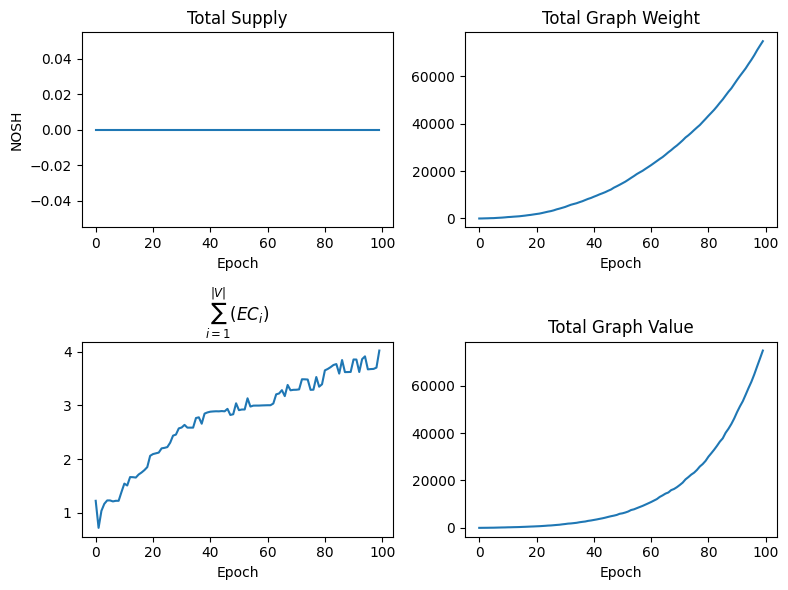

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

axx = ax[0,0]
axx.plot(total_supply_vec)
axx.set_title('Total Supply')
axx.set_xlabel('Epoch')
axx.set_ylabel('NOSH')

axx = ax[0,1]
axx.plot(total_graph_weight_list)
axx.set_title('Total Graph Weight')
axx.set_xlabel('Epoch')

axx = ax[1,0]
axx.plot(total_ec_vec)
axx.set_title(r'$\sum_{i=1}^{|V|}(EC_{i})$')
axx.set_xlabel('Epoch')


axx = ax[1,1]
axx.plot(total_graph_value_list)
axx.set_title('Total Graph Value')
axx.set_xlabel('Epoch')

plt.tight_layout()

In [93]:
seller2ec_by_t = uu.eigenvector_centrality_metric_fn(graph_evolution_metrics)
seller2totalweight_by_t = uu.total_weight_metric_fn(graph_evolution_metrics)
seller2graphvalue_by_t = uu.seller_totalvalue_metric_fn(graph_evolution_metrics)

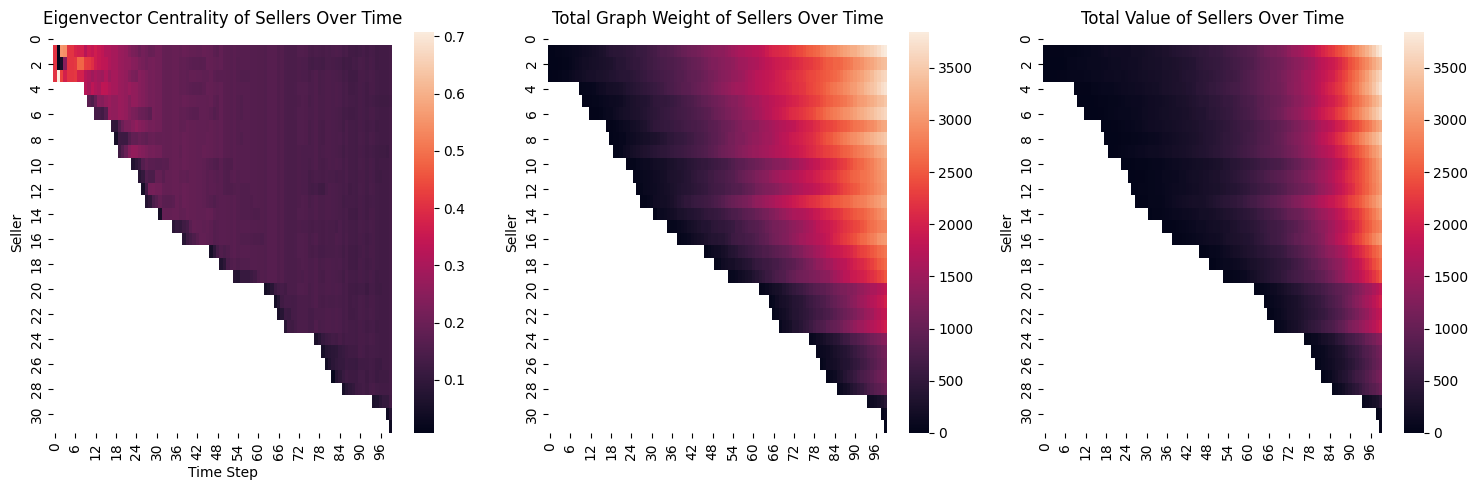

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axx = ax[0]
sns.heatmap(seller2ec_by_t, ax=axx)
axx.set_ylabel('Seller')
axx.set_xlabel('Time Step')
axx.set_title('Eigenvector Centrality of Sellers Over Time')

axx = ax[1]
sns.heatmap(seller2totalweight_by_t, ax=axx)
axx.set_ylabel('Seller')
# axx.set_xlabel('Time Step')
axx.set_title('Total Graph Weight of Sellers Over Time')

axx = ax[2]
sns.heatmap(seller2graphvalue_by_t, ax=axx)
axx.set_ylabel('Seller')
# axx.set_xlabel('Time Step')
axx.set_title('Total Value of Sellers Over Time')

plt.tight_layout()